# predict_future_output 

## Goal: predict future outputs of the various electron gun beams


In [1]:
input_file = "dataset1_clean.csv"

In [2]:
# imports:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# import utils and other models
import utils
import bla_avg_model
import bla_constant_model
import bla_linear_model
import bla_lasso_model

In [3]:
# load in cleaned dataset
data = pd.read_csv(input_file, index_col=[0], skipinitialspace=True)

# add in integer index
data = data.reset_index().reset_index().set_index(["Time"])
print(data.head())

                     index  DAC_S0_95th_quantile  DAC_S0_median  \
Time                                                              
1900-01-01 00:00:00      0                   2.0            2.0   
1900-01-01 00:01:00      1                   2.0            2.0   
1900-01-01 00:02:00      2                   2.0            2.0   
1900-01-01 00:03:00      3                   2.0            2.0   
1900-01-01 00:04:00      4                   2.0            2.0   

                     DAC_S0_5th_quantile  SO_(volts)_95th_quantile  \
Time                                                                 
1900-01-01 00:00:00                  2.0                       2.0   
1900-01-01 00:01:00                  2.0                       2.0   
1900-01-01 00:02:00                  2.0                       2.0   
1900-01-01 00:03:00                  2.0                       2.0   
1900-01-01 00:04:00                  2.0                       2.0   

                     SO_(volts)_median 

In [4]:
# (year set to 1900 since that is the base for datetime objects)
# note date ranges are not inclusive
train_date_range = ["1900-01-01", "1900-01-08"]
test_date_range = ["1900-01-08", "1900-01-10"]

full_train, test = utils.split_by_day(data, train_date_range, test_date_range)

#print(full_train.info())
#print(test.info())

In [5]:
# split full_train into a train and valdiation set
validation_frac = .1
train, validation = train_test_split(full_train, test_size=validation_frac)
#print(validation.info())
#print(train.info())

In [6]:
# convert the train and validation dataframes into a set of np arrays that can be more readily used to train models
train_X_95th, train_X_median, train_X_5th = utils.split_X_into_quantiles(train, accept_index=True)
train_Y_95th, train_Y_median, train_Y_5th = utils.split_Y_into_beams_and_quantiles(train, )

validation_X_95th, validation_X_median, validation_X_5th = utils.split_X_into_quantiles(validation, accept_index=True)
validation_Y_95th, validation_Y_median, validation_Y_5th = utils.split_Y_into_beams_and_quantiles(validation)

### Evaluation Metrics

Mean Squared Error (MSE) computed using sklearn.metrics.mean_squared_error

In [7]:
def prop_within_bounds(actual, pred_95th, pred_5th):
    # return the proportion of points in actual that fall between the predicted 5th and 95th quantiles
    num_points = actual.shape[0]
    within_upper = actual > pred_95th
    within_lower = actual < pred_5th
    within_range = np.logical_and(within_upper, within_lower)
    return np.count_nonzero(within_range) / num_points

In [8]:
def plot_single_test_mse(mses, probs, title):
    beams = list(range(1, 7))
    mse_95 = [mse[0] for mse in mses]
    mse_median = [mse[1] for mse in mses]
    mse_5 = [mse[2] for mse in mses]
    
    # See: https://matplotlib.org/gallery/api/two_scales.html
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Beam (BLA#)')
    ax1.set_ylabel('Mean Squared Error', color="Red")
    ax1.plot(beams, mse_median, 'o', color="Red")
    ax1.tick_params(axis='y', labelcolor="Red")
    ax1.set_title(title)
    
    ax2 = ax1.twinx()
    
    ax2.set_ylabel('Proportion of Samples within 5-95 range', color="Blue")
    ax2.plot(beams, probs, 'o', color="Blue")
    ax2.tick_params(axis='y', labelcolor="Blue")
    ax2.set_ylim((0, 1))
    
    fig.tight_layout()
    plt.show()

## Baseline 1: BlaConstantModel

This model averages the input for each beam over the training period and predicts that value as constant for each beam.

This represents the most naive model, since it assumes indpendence from the features and labels, and no change in the 
labels over time.

### Train Baseline 1

In [9]:
baseline_1_95 = bla_constant_model.BlaConstantModel()
baseline_1_median = bla_constant_model.BlaConstantModel()
baseline_1_5 = bla_constant_model.BlaConstantModel()

baseline_1_95.train(train_X_median, train_Y_95th)
baseline_1_median.train(train_X_median, train_Y_median)
baseline_1_5.train(train_X_median, train_Y_5th)

baseline_1_pred_95 = [baseline_1_95.predict(validation_X_median, i) for i in range(6)]
baseline_1_pred_median = [baseline_1_median.predict(validation_X_median, i) for i in range(6)]
baseline_1_pred_5 = [baseline_1_5.predict(validation_X_median, i) for i in range(6)]


### Validate Baseline 1

In [10]:
baseline_1_valid_props = []
for i in range(6):
    p = prop_within_bounds(validation_Y_median[i], baseline_1_pred_95[i], baseline_1_pred_5[i])
    baseline_1_valid_props.append(p)
    
print(baseline_1_valid_props)

baseline_1_valid_mses = []
for i in range(6):
    mse_95 = mean_squared_error(validation_Y_95th[i], baseline_1_pred_95[i])
    mse_median = mean_squared_error(validation_Y_median[i], baseline_1_pred_median[i])
    mse_5 = mean_squared_error(validation_Y_5th[i], baseline_1_pred_5[i])
    baseline_1_valid_mses.append([mse_95, mse_median, mse_5])
    
print(baseline_1_valid_mses)

[0.30456349206349204, 0.498015873015873, 0.17559523809523808, 0.44543650793650796, 0.1875, 0.37202380952380953]
[[0.04245452300948678, 0.04162106729108527, 0.04147491664407876], [0.03209213029749671, 0.03142353916074882, 0.03155583052803947], [0.26960116110097515, 0.2642658944906552, 0.25920467174609846], [0.029267750765246982, 0.02846044405023367, 0.028371323893824553], [0.11985529057687967, 0.11808436889468066, 0.11775065138880612], [0.0638961255313746, 0.060582924020874236, 0.05866753512445516]]


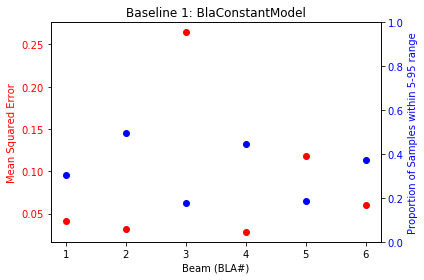

In [11]:
plot_single_test_mse(baseline_1_valid_mses, baseline_1_valid_props, "Baseline 1: BlaConstantModel")

## Baseline 2: BlaAvgModel
This model ignores differences in beams and tries to fit a single model for all beams by averaging the output from all
beams into a single "y" before fitting.

### Train Baseline 2

In [12]:
baseline_2_95 = bla_avg_model.BlaAvgModel()
baseline_2_median = bla_avg_model.BlaAvgModel()
baseline_2_5 = bla_avg_model.BlaAvgModel()

baseline_2_95.train(train_X_median, train_Y_95th)
baseline_2_median.train(train_X_median, train_Y_median)
baseline_2_5.train(train_X_median, train_Y_5th)

baseline_2_pred_95 = baseline_2_95.predict(validation_X_median)
baseline_2_pred_median = baseline_2_median.predict(validation_X_median)
baseline_2_pred_5 = baseline_2_5.predict(validation_X_median)

### Validate Baseline 2

In [13]:
baseline_2_valid_props = []
for i in range(6):
    p = prop_within_bounds(validation_Y_median[i], baseline_2_pred_95, baseline_2_pred_5)
    baseline_2_valid_props.append(p)
    
print(baseline_2_valid_props)

baseline_2_valid_mses = []
for i in range(6):
    mse_95 = mean_squared_error(validation_Y_95th[i], baseline_2_pred_95)
    mse_median = mean_squared_error(validation_Y_median[i], baseline_2_pred_median)
    mse_5 = mean_squared_error(validation_Y_5th[i], baseline_2_pred_5)
    baseline_2_valid_mses.append([mse_95, mse_median, mse_5])
    
print(baseline_2_valid_mses)

[0.0, 0.001984126984126984, 0.0, 0.0, 0.4751984126984127, 0.0]
[[17.94122108121442, 17.923711036868358, 17.902940451881435], [0.3666488186208944, 0.32765771481748734, 0.28837861968281575], [0.863417050277435, 0.8385345258291204, 0.8184678414446253], [13.154606625818724, 13.384280903935094, 13.605719156742488], [0.05684638257268575, 0.06083571607881281, 0.06547999911253083], [0.8893476943905664, 0.9080191230458328, 0.9225798980226455]]


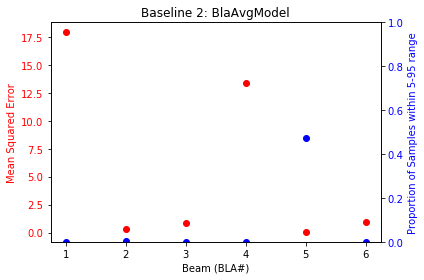

In [14]:
plot_single_test_mse(baseline_2_valid_mses, baseline_2_valid_props, "Baseline 2: BlaAvgModel")

## Model 1: Regular Least Squares Regression for Each Beam
This model trains a regular least squares model for each beam independtly. Parameters for the least squares model are
standard, and an intercept is added.

### Train Model 1

In [15]:
model_1_95 = bla_linear_model.BlaLinearModel()
model_1_median = bla_linear_model.BlaLinearModel()
model_1_5 = bla_linear_model.BlaLinearModel()

model_1_95.train(train_X_median, train_Y_95th)
model_1_median.train(train_X_median, train_Y_median)
model_1_5.train(train_X_median, train_Y_5th)

model_1_pred_95 = [model_1_95.predict(validation_X_median, i) for i in range(6)]
model_1_pred_median = [model_1_median.predict(validation_X_median, i) for i in range(6)]
model_1_pred_5 = [model_1_5.predict(validation_X_median, i) for i in range(6)]

### Validate Model 1


In [16]:
model_1_valid_props = []
for i in range(6):
    p = prop_within_bounds(validation_Y_median[i], model_1_pred_95[i], model_1_pred_5[i])
    model_1_valid_props.append(p)
    print(model_1_median.models[i].score(validation_X_median, validation_Y_median[i]))
    
print(model_1_valid_props)

model_1_valid_mses = []
for i in range(6):
    mse_95 = mean_squared_error(validation_Y_95th[i], model_1_pred_95[i])
    mse_median = mean_squared_error(validation_Y_median[i], model_1_pred_median[i])
    mse_5 = mean_squared_error(validation_Y_5th[i], model_1_pred_5[i])
    model_1_valid_mses.append([mse_95, mse_median, mse_5])
    
print(model_1_valid_mses)

0.8181795211386911
0.827241925281234
0.9532337407185812
0.8872118653940038
0.9744355894497458
0.693275627690665
[0.7698412698412699, 0.9255952380952381, 0.7470238095238095, 0.7509920634920635, 0.8045634920634921, 0.5863095238095238]
[[0.007860981224111014, 0.007533497647705936, 0.007806739348057088], [0.005666978178580184, 0.005426269196367627, 0.006309557660438183], [0.014626180286519769, 0.012358204445914336, 0.012144149184415838], [0.0033471164185337227, 0.0032091294248332604, 0.003229270002345278], [0.00338765905386192, 0.0030149984398348323, 0.003110811621841869], [0.02016941555978482, 0.018549033944698628, 0.017700811907873617]]


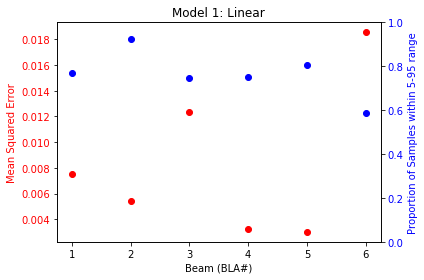

In [17]:
plot_single_test_mse(model_1_valid_mses, model_1_valid_props, "Model 1: Linear")

## Model 2: Lasso (Linear Regression with L1 Regularization)
This model adds a l1 regularization term to the objective function. This has the effect of penalizing nonzero coefficients,
which in turn minimizes the number of nonzero coefficients. 

### Train Model 2

In [18]:
model_2_95 = bla_lasso_model.BlaLassoModel(alpha=1)
model_2_median = bla_lasso_model.BlaLassoModel(alpha=1)
model_2_5 = bla_lasso_model.BlaLassoModel(alpha=1)

model_2_95.train(train_X_median, train_Y_95th)
model_2_median.train(train_X_median, train_Y_median)
model_2_5.train(train_X_median, train_Y_5th)

model_2_pred_95 = [model_2_95.predict(validation_X_median, i) for i in range(6)]
model_2_pred_median = [model_2_median.predict(validation_X_median, i) for i in range(6)]
model_2_pred_5 = [model_2_5.predict(validation_X_median, i) for i in range(6)]

### Validate Model 2

In [19]:
model_2_valid_props = []
for i in range(6):
    p = prop_within_bounds(validation_Y_median[i], model_2_pred_95[i], model_2_pred_5[i])
    model_2_valid_props.append(p)
    #print(model_2_median.models[i].coef_, model_2_median.models[i].intercept_)
    #print(model_2_median.models[i].score(validation_X_median, validation_Y_median[i]))
    
print(model_2_valid_props)

model_2_valid_mses = []
for i in range(6):
    mse_95 = mean_squared_error(validation_Y_95th[i], model_2_pred_95[i])
    mse_median = mean_squared_error(validation_Y_median[i], model_2_pred_median[i])
    mse_5 = mean_squared_error(validation_Y_5th[i], model_2_pred_5[i])
    model_2_valid_mses.append([mse_95, mse_median, mse_5])
    
print(model_2_valid_mses)

[0.3115079365079365, 0.8283730158730159, 0.26587301587301587, 0.5634920634920635, 0.6468253968253969, 0.4236111111111111]
[[0.03871993840535931, 0.03796806827895438, 0.03758122605700853], [0.01154962699014436, 0.011415920505618548, 0.01208235684124185], [0.2436782640761842, 0.23897594414904175, 0.234166894376327], [0.022409077778951254, 0.02176517619755074, 0.021588929090232616], [0.007378968292477645, 0.006856814970724178, 0.006864312756117084], [0.05723374027422613, 0.054352662515898445, 0.05289960857780515]]


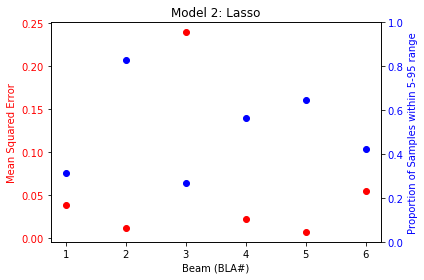

In [20]:
plot_single_test_mse(model_2_valid_mses, model_2_valid_props, "Model 2: Lasso")

In [21]:
# evaluate models:
# split test set into a set of np arrays that can be more readily used to generate model predictions
test_X_95th, test_X_median, test_X_5th = utils.split_X_into_quantiles(test)
test_Y_95th, test_Y_median, test_Y_5th = utils.split_Y_into_beams_and_quantiles(test)